In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
df = pd.read_csv('../Kaggle_dataset/ACWV4.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,48.919998,49.070000,48.709999,49.040001,41.957142,2298300
1,1/3/2013,48.810001,49.080002,48.720001,48.830002,41.777470,1567500
2,1/4/2013,48.840000,49.099998,48.750000,49.040001,41.957142,1400200
3,1/7/2013,48.790001,48.889999,48.669998,48.840000,41.786026,1497400
4,1/8/2013,48.709999,48.750000,48.430000,48.599998,41.580692,306300


In [3]:
def buy_stock(
    real_movement,
    delay = 5,
    initial_state = 1,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    delay_change_decision = delay
    current_decision = 0
    state = initial_state
    current_val = real_movement[0]
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    if state == 1:
        initial_money, current_inventory = buy(
            0, initial_money, current_inventory
        )

    for i in range(1, real_movement.shape[0], 1):
        if real_movement[i] < current_val and state == 0:
            if current_decision < delay_change_decision:
                current_decision += 1
            else:
                state = 1
                initial_money, current_inventory = buy(
                    i, initial_money, current_inventory
                )
                current_decision = 0
                states_buy.append(i)
        if real_movement[i] > current_val and state == 1:
            if current_decision < delay_change_decision:
                current_decision += 1
            else:
                state = 0

                if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
                else:
                    if current_inventory > max_sell:
                        sell_units = max_sell
                    else:
                        sell_units = current_inventory
                    current_inventory -= sell_units
                    total_sell = sell_units * real_movement[i]
                    initial_money += total_sell
                    try:
                        invest = (
                            (real_movement[i] - real_movement[states_buy[-1]])
                            / real_movement[states_buy[-1]]
                        ) * 100
                    except:
                        invest = 0
                    print(
                        'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                        % (i, sell_units, total_sell, invest, initial_money)
                    )

                current_decision = 0
                states_sell.append(i)
        current_val = real_movement[i]
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [4]:
states_buy, states_sell, total_gains, invest = buy_stock(df.Close, initial_state = 1, 
                                                         delay = 4, initial_money = 10000)

day 0: buy 1 units at price 49.040001, total balance 9950.959999
day 11, sell 1 units at price 49.520000, investment 0.978792 %, total balance 10000.480000,
day 22: buy 1 units at price 49.630001, total balance 9950.849998
day 29, sell 1 units at price 50.279999, investment 1.309687 %, total balance 10001.129997,
day 36: buy 1 units at price 49.029999, total balance 9952.099998
day 42, sell 1 units at price 50.459999, investment 2.916582 %, total balance 10002.559998,
day 52: buy 1 units at price 50.400002, total balance 9952.159996
day 61, sell 1 units at price 50.720001, investment 0.634920 %, total balance 10002.879997,
day 72: buy 1 units at price 50.119999, total balance 9952.759998
day 78, sell 1 units at price 51.599998, investment 2.952912 %, total balance 10004.359997,
day 93: buy 1 units at price 53.330002, total balance 9951.029995
day 102, sell 1 units at price 52.910000, investment -0.787553 %, total balance 10003.939995,
day 110: buy 1 units at price 51.450001, total bala

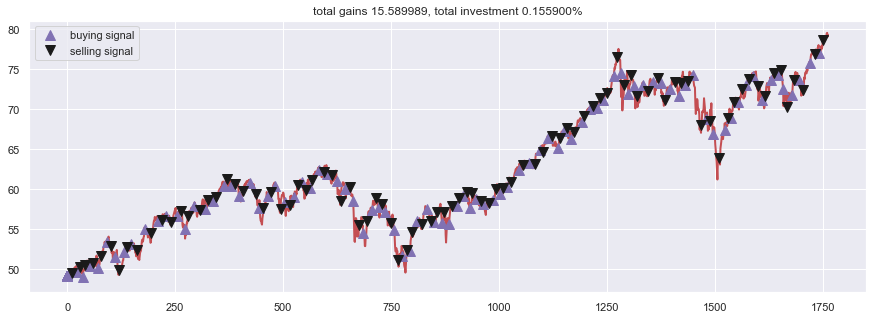

In [5]:
close = df['Close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()